# LSTM MODELS 2

In this notebook, we are going to fit LSTM models by using the dataset with COVID data.

### 📑 Index
* [1. MODEL WITH BEST PARAMETERS (I)](#1)
* [2. MODEL WITH BEST PARAMETERS (II)](#2)
* [3. MODEL WITH BEST PARAMETERS (III)](#3)

Import the packages.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import random

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

import warnings
warnings.filterwarnings("ignore")

from pylab import rcParams
plt.style.use("fivethirtyeight")
plt.rcParams["lines.linewidth"] = 1.5
dark_style = {
    "figure.facecolor": "#212946",
    "axes.facecolor": "#212946",
    "savefig.facecolor": "#212946",
    "axes.grid": True,
    "axes.grid.which": "both",
    "axes.spines.left": False,
    "axes.spines.right": False,
    "axes.spines.top": False,
    "axes.spines.bottom": False,
    "grid.color": "#2A3459",
    "grid.linewidth": "1",
    "text.color": "0.6",
    "axes.labelcolor": "0.6",
    "xtick.color": "0.6",
    "ytick.color": "0.6",
    "font.size": 12,
}
plt.rcParams.update(dark_style)
rcParams["figure.figsize"] = (18, 7)

Load the data and consider that our data set goes from 2003 to 2023 (WITH COVID).

In [2]:
df = pd.read_csv(
    "C:/Users/Juanfran cd/Desktop/MATEMATICAS UA/TFG/air traffic.csv",
    encoding="ISO-8859-1",
)

# Clean and convert 'Pax' to number
df["Pax"] = df["Pax"].str.replace(",", "", regex=True).astype(float)

# Create date column in YYYY-MM format
df["Date"] = pd.to_datetime(
    df["Year"].astype(str) + "-" + df["Month"].astype(str).str.zfill(2), format="%Y-%m"
)

# Keep only the 'Date' and 'Pax' columns
df1 = df[["Date", "Pax"]]

Split the data set into 2: a training set (from 2003 to 2021, that is 228 values) and a test set (from 2022 to 2023, that is 21 values).

In [3]:
train = df1.loc[df1["Date"] <= "2021-12-01"]
test = df1.loc[df1["Date"] >= "2021-01-01"]

In [4]:
len(train), len(test)  

(228, 33)

Plot of Training-Test split

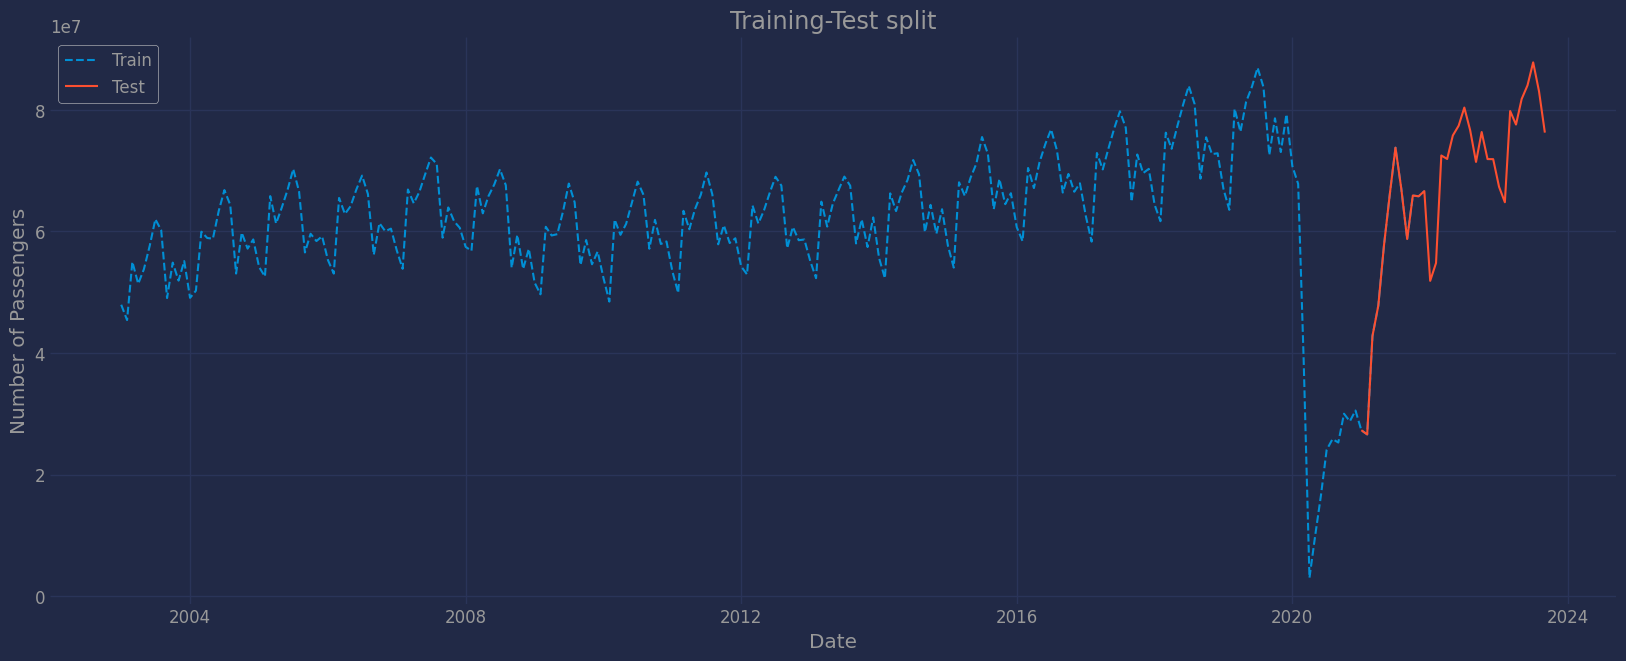

In [5]:
sns.lineplot(data=train, x="Date", y="Pax", label="Train", linestyle="--")
sns.lineplot(data=test, x="Date", y="Pax", label="Test")
plt.title("Training-Test split")
plt.ylabel("Number of Passengers")
plt.show()

Scale the data.

In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
train["Pax"] = scaler.fit_transform(train[["Pax"]])
test["Pax"] = scaler.transform(test[["Pax"]])
scaled_data = scaler.transform(df1[["Pax"]])

<a id='1'></a>
## 1. MODEL WITH BEST PARAMETERS (I)

In [7]:
def create_dataset(data, input_size):
    valores = data.iloc[:, 1].values.astype(np.float32)

    X, y = [], []
    for i in range(len(valores) - input_size - 1):
        a = valores[i:(i + input_size)]
        X.append(a)
        y.append(valores[i + input_size])
        
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

In [ ]:
param_grid = {
    "units": [30, 50],
    "optimizer": ["adam", "rmsprop"],
    "epochs": [50, 75,100],
    "batch_size": [16, 32, 64],
    "input_size": [12, 24]
}

best_model = None
best_mse = float("inf")
best_params = None

for units in param_grid["units"]:
    for opt in param_grid["optimizer"]:
        for epochs in param_grid["epochs"]:
            for batch in param_grid["batch_size"]:
                for input_size in param_grid["input_size"]:
                    print(f"Probando: units={units}, optimizer={opt}, epochs={epochs}, batch_size={batch}, input_size={input_size}")

                    if input_size == 12:
                        test = test
                    elif input_size == 24:
                        test = df1.loc[df1["Date"] >= "2020-01-01"]

                    # Create data sets with fixed time_step
                    X_train, y_train = create_dataset(train, input_size)
                    X_test, y_test = create_dataset(test, input_size)

                    # Reshape data for LSTM model
                    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
                    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

                    # Make new model
                    model = Sequential()
                    model.add(LSTM(units, return_sequences=True, input_shape=(X_train.shape[1], 1)))
                    model.add(LSTM(units, return_sequences=False))
                    model.add(Dense(1))

                    model.compile(optimizer=opt, loss="mean_squared_error")

                    # Training
                    model.fit(X_train, y_train, epochs=epochs, batch_size=batch, verbose=0)

                    # Forecasting and evaluation
                    test_pred = model.predict(X_test)
                    test_pred_inv = scaler.inverse_transform(test_pred)
                    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

                    mse = mean_squared_error(y_test_inv, test_pred_inv)

                    print(f"--> MSE: {mse:.4f}")

                    if mse < best_mse:
                        best_mse = mse
                        best_model = model
                        best_params = {
                            "units": units,
                            "optimizer": opt,
                            "epochs": epochs,
                            "batch_size": batch,
                            "input_size": input_size
                        }

print("\n✅ Best parameters:")
print(f"Params: {best_params}")

In [9]:
# Best parameters:
units1 = 30 
optimizer1 = 'adam' 
epochs1 = 50
batch_size1 = 16 
input_size1= 12

In [10]:
X_train1, y_train1 = create_dataset(train, input_size1)
X_test1, y_test1 = create_dataset(test, input_size1)

X_train1 = X_train1.reshape(X_train1.shape[0], X_train1.shape[1], 1)
X_test1 = X_test1.reshape(X_test1.shape[0], X_test1.shape[1], 1)

Train and fit the model with best parameters.

In [11]:
# Fix seed for reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model1 = Sequential()
model1.add(LSTM(units1, return_sequences=True, input_shape=(X_train1.shape[1], 1)))  
model1.add(LSTM(units1, return_sequences=False))
model1.add(Dense(1))

model1.compile(optimizer=optimizer1, loss="mean_squared_error")

In [12]:
model1.fit(X_train1, y_train1, epochs=epochs1, batch_size=batch_size1, verbose=1)

Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.2619
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0397
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0222
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0173
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0169
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0164
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0164
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0162
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0161
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0160
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0159
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0157
Epoch 13/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0156
Epoch 14/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0155
Epoch 15/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0153
Epoc

In [13]:
train_predict1 = model1.predict(X_train1)
test_predict1 = model1.predict(X_test1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


In [14]:
train_predict1 = scaler.inverse_transform(train_predict1)
test_predict1 = scaler.inverse_transform(test_predict1)
y_train_inv1 = scaler.inverse_transform(y_train1.reshape(-1, 1))
y_test_inv1 = scaler.inverse_transform(y_test1.reshape(-1, 1))

Error metrics with best parameters

In [15]:
print("\n🔹 Training set metrics:")
print(f"MAE: {mean_absolute_error(y_train_inv1, train_predict1):.2f}")
print(f"MAPE: {mean_absolute_percentage_error(y_train_inv1, train_predict1) * 100:.2f}%")

print("\n🔹 Test set metrics:")
print(f"MAE: {mean_absolute_error(y_test_inv1, test_predict1):.2f}")
print(f"MAPE: {mean_absolute_percentage_error(y_test_inv1, test_predict1) * 100:.2f}%")


🔹 Training set metrics:
MAE: 6244940.00
MAPE: 19.15%

🔹 Test set metrics:
MAE: 9891581.00
MAPE: 13.18%


In [16]:
train_plot1 = np.empty_like(scaled_data)
train_plot1[:, :] = np.nan
train_plot1[input_size1 : len(train_predict1) + input_size1, :] = train_predict1

test_plot1 = np.empty_like(scaled_data)
test_plot1[:, :] = np.nan
test_plot1[len(train_predict1) - 12 + (input_size1* 2) + 1 : len(df1) - 1, :] = test_predict1

Plot of the forecasting

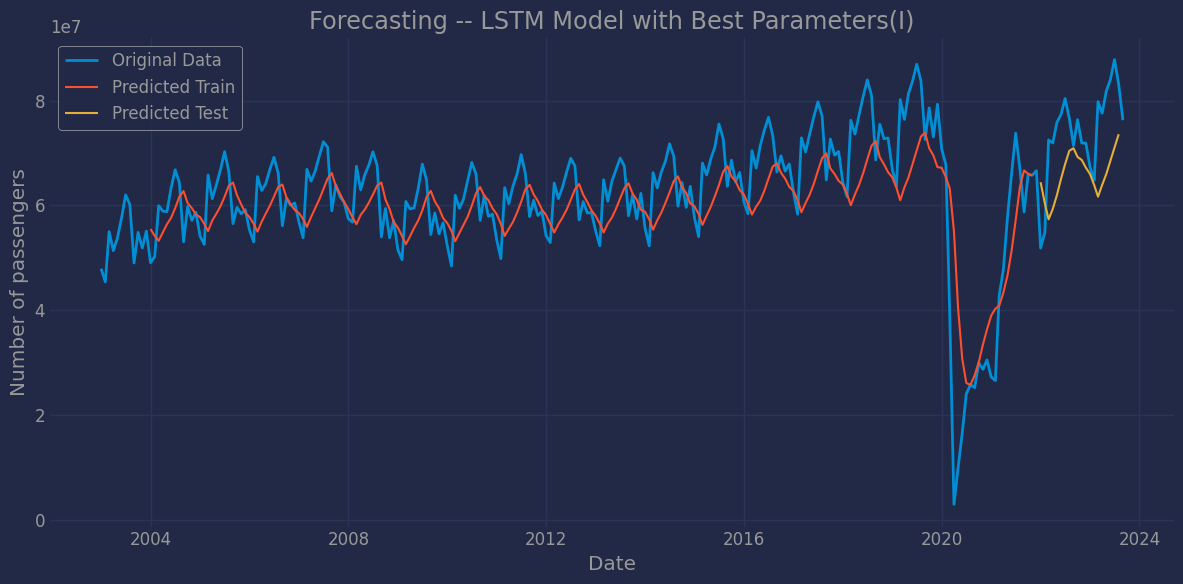

In [17]:
original_pax = df1["Pax"].values.reshape(-1, 1)
plt.figure(figsize=(12, 6))
plt.plot(df1["Date"], original_pax, label="Original Data", linewidth=2)
plt.plot(df1["Date"], train_plot1, label="Predicted Train")
plt.plot(df1["Date"], test_plot1, label="Predicted Test")
plt.title("Forecasting -- LSTM Model with Best Parameters(I)")
plt.xlabel("Date")
plt.ylabel("Number of passengers")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<a id='2'></a>
## 2. MODEL WITH BEST PARAMETERS (II)

Now, since the errors are quite great, let's fit another model by changing paremeters.

In [ ]:
param_grid = {
    "units": [64, 100],                      
    "optimizer": ["adam", "nadam"],           
    "epochs": [120, 150],                     
    "batch_size": [8, 16, 32],              
    "input_size": [12, 24]               
}


best_model = None
best_mse = float("inf")
best_params = None

for units in param_grid["units"]:
    for opt in param_grid["optimizer"]:
        for epochs in param_grid["epochs"]:
            for batch in param_grid["batch_size"]:
                for input_size in param_grid["input_size"]:
                    print(f"Probando: units={units}, optimizer={opt}, epochs={epochs}, batch_size={batch}, input_size={input_size}")

                    if input_size == 12:
                        test = test
                    elif input_size == 24:
                        test = df1.loc[df1["Date"] >= "2020-01-01"]

                    # Create data sets with fixed time_step
                    X_train, y_train = create_dataset(train, input_size)
                    X_test, y_test = create_dataset(test, input_size)

                    # Reshape data for LSTM model
                    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
                    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

                    # Make new model
                    model = Sequential()
                    model.add(LSTM(units, return_sequences=True, input_shape=(X_train.shape[1], 1)))
                    model.add(LSTM(units, return_sequences=False))
                    model.add(Dense(1))

                    model.compile(optimizer=opt, loss="mean_squared_error")

                    # Training
                    model.fit(X_train, y_train, epochs=epochs, batch_size=batch, verbose=0)

                    # Forecasting and evaluation
                    test_pred = model.predict(X_test)
                    test_pred_inv = scaler.inverse_transform(test_pred)
                    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

                    mse = mean_squared_error(y_test_inv, test_pred_inv)

                    print(f"--> MSE: {mse:.4f}")

                    if mse < best_mse:
                        best_mse = mse
                        best_model = model
                        best_params = {
                            "units": units,
                            "optimizer": opt,
                            "epochs": epochs,
                            "batch_size": batch,
                            "input_size": input_size
                        }

print("\n✅ Best parameters:")
print(f"Params: {best_params}")

In [19]:
# Best parameters:
units2 = 64 
optimizer2 = 'adam' 
epochs2 = 150 
batch_size2 = 16
input_size2= 12

In [20]:
X_train2, y_train2 = create_dataset(train, input_size2)
X_test2, y_test2 = create_dataset(test, input_size2)

X_train2 = X_train2.reshape(X_train2.shape[0], X_train2.shape[1], 1)
X_test2 = X_test2.reshape(X_test2.shape[0], X_test2.shape[1], 1)

Train and fit the model with best parameters.

In [21]:
# Fix seed for reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model2 = Sequential()
model2.add(LSTM(units2, return_sequences=True, input_shape=(X_train2.shape[1], 1)))  #50 celdas en cada capa
model2.add(LSTM(units2, return_sequences=False))
model2.add(Dense(1))

model2.compile(optimizer=optimizer2, loss="mean_squared_error")

In [22]:
model2.fit(X_train2, y_train2, epochs=epochs2, batch_size=batch_size2, verbose=1)

Epoch 1/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.2215
Epoch 2/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0230
Epoch 3/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0166
Epoch 4/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0168
Epoch 5/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0156
Epoch 6/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0154
Epoch 7/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0153
Epoch 8/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0151
Epoch 9/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0150
Epoch 10/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0149
Epoch 11/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0148
Epoch 12/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0146
Epoch 13/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0145
Epoch 14/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0144
Epoch 15/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - lo

In [23]:
train_predict2 = model2.predict(X_train2)
test_predict2 = model2.predict(X_test2)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


In [24]:
train_predict2 = scaler.inverse_transform(train_predict2)
test_predict2 = scaler.inverse_transform(test_predict2)
y_train_inv2 = scaler.inverse_transform(y_train2.reshape(-1, 1))
y_test_inv2 = scaler.inverse_transform(y_test2.reshape(-1, 1))

Error metrics

In [25]:
print("\n🔹 Training set metrics:")
print(f"MAE: {mean_absolute_error(y_train_inv2, train_predict2):.2f}")
print(f"MAPE: {mean_absolute_percentage_error(y_train_inv2, train_predict2) * 100:.2f}%")

print("\n🔹 Test set metrics:")
print(f"MAE: {mean_absolute_error(y_test_inv2, test_predict2):.2f}")
print(f"MAPE: {mean_absolute_percentage_error(y_test_inv2, test_predict2) * 100:.2f}%")


🔹 Training set metrics:
MAE: 4175704.00
MAPE: 12.02%

🔹 Test set metrics:
MAE: 4669234.00
MAPE: 6.44%


In [26]:
train_plot2 = np.empty_like(scaled_data)
train_plot2[:, :] = np.nan
train_plot2[input_size2 : len(train_predict2) + input_size2, :] = train_predict2

test_plot2 = np.empty_like(scaled_data)
test_plot2[:, :] = np.nan
test_plot2[len(train_predict2) - 12 + (input_size2* 2) + 1 : len(df1) - 1, :] = test_predict2

Plot of the forecasting

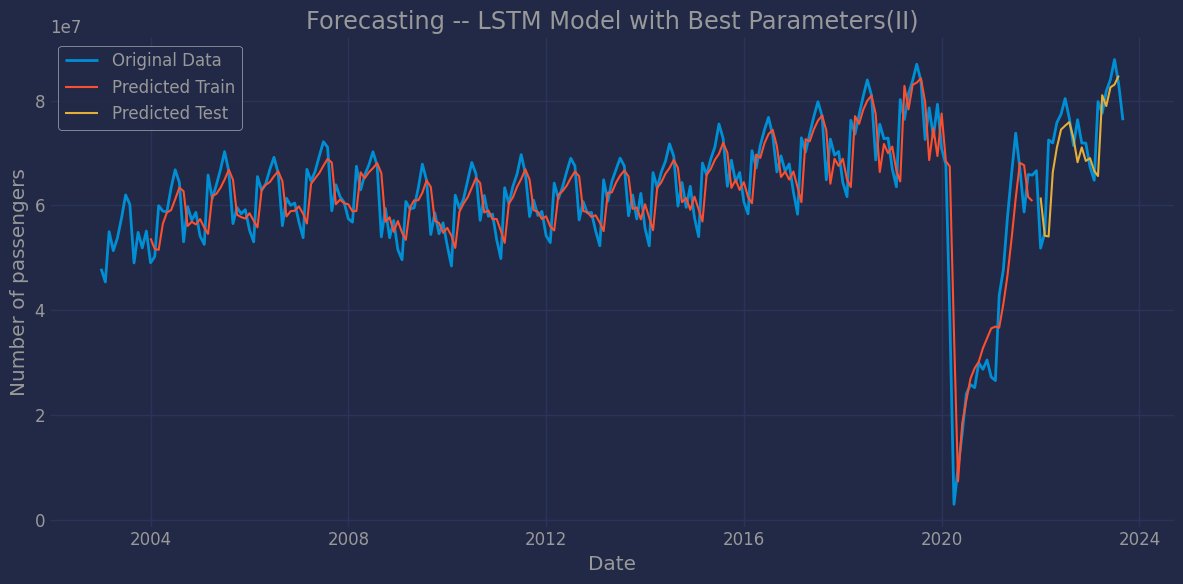

In [27]:
original_pax = df1["Pax"].values.reshape(-1, 1)
plt.figure(figsize=(12, 6))
plt.plot(df1["Date"], original_pax, label="Original Data", linewidth=2)
plt.plot(df1["Date"], train_plot2, label="Predicted Train")
plt.plot(df1["Date"], test_plot2, label="Predicted Test")
plt.title("Forecasting -- LSTM Model with Best Parameters(II)")
plt.xlabel("Date")
plt.ylabel("Number of passengers")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("../graphics/LSTM_con_covid/fore_best_lstm_con_covid", dpi=300, bbox_inches="tight")
plt.show()

<a id='3'></a>
## 3. MODEL WITH BEST PARAMETERS (III)

In [ ]:
param_grid = {
    "units": [30, 50, 64, 100],
    "optimizer": ["adam", "rmsprop", "nadam"],
    "epochs": [50, 75, 100, 120, 150],
    "batch_size": [8, 16, 32, 64],
    "input_size": [12, 24]
}

best_model = None
best_mse = float("inf")
best_params = None

for units in param_grid["units"]:
    for opt in param_grid["optimizer"]:
        for epochs in param_grid["epochs"]:
            for batch in param_grid["batch_size"]:
                for input_size in param_grid["input_size"]:
                    print(f"Probando: units={units}, optimizer={opt}, epochs={epochs}, batch_size={batch}, input_size={input_size}")

                    if input_size == 12:
                        test = test
                    elif input_size == 24:
                        test = df1.loc[df1["Date"] >= "2020-01-01"]

                    # Create data sets with fixed time_step
                    X_train, y_train = create_dataset(train, input_size)
                    X_test, y_test = create_dataset(test, input_size)

                    # Reshape data for LSTM model
                    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
                    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

                    # Make new model
                    model = Sequential()
                    model.add(LSTM(units, return_sequences=True, input_shape=(X_train.shape[1], 1)))
                    model.add(LSTM(units, return_sequences=False))
                    model.add(Dense(1))

                    model.compile(optimizer=opt, loss="mean_squared_error")

                    # Training
                    model.fit(X_train, y_train, epochs=epochs, batch_size=batch, verbose=0)

                    # Forecasting and evaluation
                    test_pred = model.predict(X_test)
                    test_pred_inv = scaler.inverse_transform(test_pred)
                    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

                    mse = mean_squared_error(y_test_inv, test_pred_inv)

                    print(f"--> MSE: {mse:.4f}")

                    if mse < best_mse:
                        best_mse = mse
                        best_model = model
                        best_params = {
                            "units": units,
                            "optimizer": opt,
                            "epochs": epochs,
                            "batch_size": batch,
                            "input_size": input_size
                        }

print("\n✅ Best parameters:")
print(f"Params: {best_params}")

In [29]:
# Best parameters:
units3 = 30
optimizer3 = 'adam' 
epochs3 = 50 
batch_size3 = 8 
input_size3= 12

In [30]:
X_train3, y_train3 = create_dataset(train, input_size3)
X_test3, y_test3 = create_dataset(test, input_size3)

X_train3 = X_train3.reshape(X_train3.shape[0], X_train3.shape[1], 1)
X_test3 = X_test3.reshape(X_test3.shape[0], X_test3.shape[1], 1)

Train and fit the model with best parameters.

In [31]:
# Fix seed for reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model3 = Sequential()
model3.add(LSTM(units3, return_sequences=True, input_shape=(X_train3.shape[1], 1)))  
model3.add(LSTM(units3, return_sequences=False))
model3.add(Dense(1))

model3.compile(optimizer=optimizer3, loss="mean_squared_error")

In [32]:
model3.fit(X_train3, y_train3, epochs=epochs3, batch_size=batch_size3, verbose=1)

Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.1930
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0233
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0180
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0175
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0173
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0171
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0168
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0165
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0161
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0158
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0155
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0151
Epoch 13/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0148
Epoch 14/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0145
Epoch 15/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0141
Epoch 16/50

In [33]:
train_predict3 = model3.predict(X_train3)
test_predict3 = model3.predict(X_test3)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


In [34]:
train_predict3 = scaler.inverse_transform(train_predict3)
test_predict3 = scaler.inverse_transform(test_predict3)
y_train_inv3 = scaler.inverse_transform(y_train3.reshape(-1, 1))
y_test_inv3 = scaler.inverse_transform(y_test3.reshape(-1, 1))

Error metrics

In [35]:
print("\n🔹 Training set metrics:")
print(f"MAE: {mean_absolute_error(y_train_inv3, train_predict3):.2f}")
print(f"MAPE: {mean_absolute_percentage_error(y_train_inv3, train_predict3) * 100:.2f}%")

print("\n🔹 Test set metrics:")
print(f"MAE: {mean_absolute_error(y_test_inv3, test_predict3):.2f}")
print(f"MAPE: {mean_absolute_percentage_error(y_test_inv3, test_predict3) * 100:.2f}%")


🔹 Training set metrics:
MAE: 4661372.00
MAPE: 15.34%

🔹 Test set metrics:
MAE: 6100780.00
MAPE: 8.26%


In [36]:
train_plot3 = np.empty_like(scaled_data)
train_plot3[:, :] = np.nan
train_plot3[input_size3 : len(train_predict3) + input_size3, :] = train_predict3

test_plot3 = np.empty_like(scaled_data)
test_plot3[:, :] = np.nan
test_plot3[len(train_predict3) - 12 + (input_size3* 2) + 1 : len(df1) - 1, :] = test_predict3

Plot of the forecasting

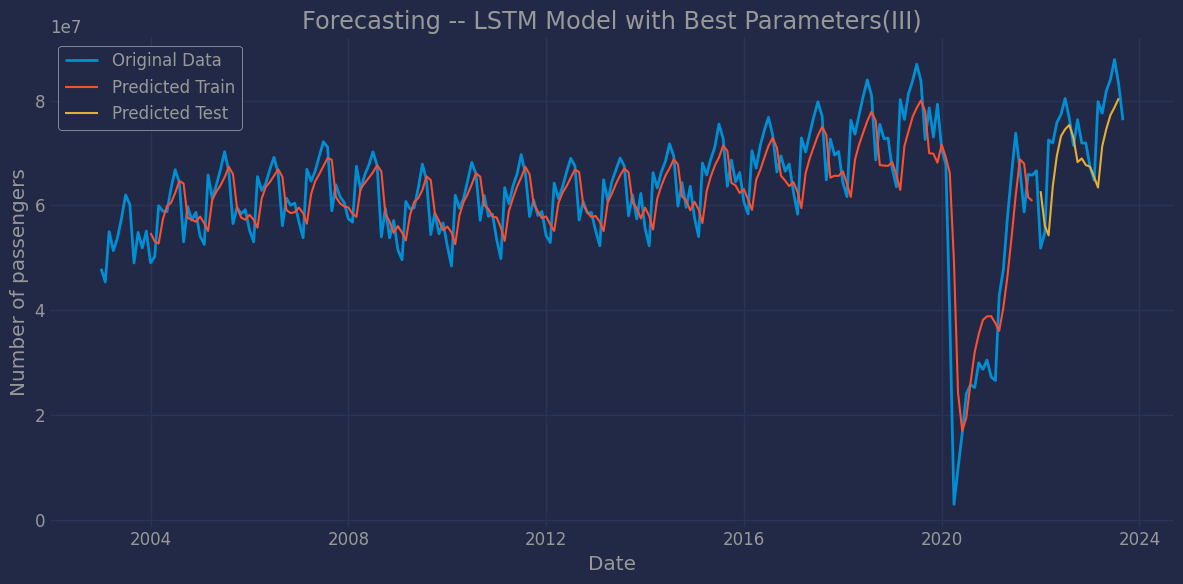

In [37]:
original_pax = df1["Pax"].values.reshape(-1, 1)
plt.figure(figsize=(12, 6))
plt.plot(df1["Date"], original_pax, label="Original Data", linewidth=2)
plt.plot(df1["Date"], train_plot3, label="Predicted Train")
plt.plot(df1["Date"], test_plot3, label="Predicted Test")
plt.title("Forecasting -- LSTM Model with Best Parameters(III)")
plt.xlabel("Date")
plt.ylabel("Number of passengers")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()